# Laboratorium 2


### Konfiguracja

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js

class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes

    def set_axis(self, ax):
        self.ax = ax
        
    def next(self, event):
        self.i = (self.i + 1) % len(scenes)
        self.draw()

    def prev(self, event):
        self.i = (self.i - 1) % len(scenes)
        self.draw()
        
    def draw(self):
        self.ax.clear()
        for collection in self.scenes[self.i].points:
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), c=collection.color, marker=collection.marker)
        for collection in self.scenes[self.i].lines:
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale()
        plt.draw()

### Interfejsy

[Dostępne kolory](https://matplotlib.org/3.1.1/gallery/color/named_colors.html)

[Dostępne znaczniki punktów](https://matplotlib.org/3.1.1/api/markers_api.html#module-matplotlib.markers)

In [2]:
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

class PointsCollection:
    def __init__(self, points = [], color = None, marker = None):
        self.points = np.array(points)
        self.color = color
        self.marker = marker

class LinesCollection:
    def __init__(self, lines = [], color = None):
        self.color = color
        self.lines = lines
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        if self.color:
            return mcoll.LineCollection(self.lines, colors=mcolors.to_rgba(self.color))
        else:
            return mcoll.LineCollection(self.lines)
            


class Plot:
    def __init__(self, scenes = [], json = None):
        if json is None:
            self.scenes = scenes
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
        
    def __configure_buttons(self, callback):
        plt.subplots_adjust(bottom=0.2)
        axprev = plt.axes([0.6, 0.05, 0.15, 0.075])
        axnext = plt.axes([0.76, 0.05, 0.15, 0.075])
        bnext = Button(axnext, 'Następny')
        bnext.on_clicked(callback.next)
        bprev = Button(axprev, 'Poprzedni')
        bprev.on_clicked(callback.prev)
        return [bprev, bnext]

    def draw(self):
        plt.close()
        callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons(callback)
        callback.set_axis(plt.axes())
        plt.show()
        callback.draw()
        
    def toJSON(self):
        return js.dumps([{"points": [pointCol.points.tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])
    

### Przykład użycia

<IPython.core.display.Javascript object>


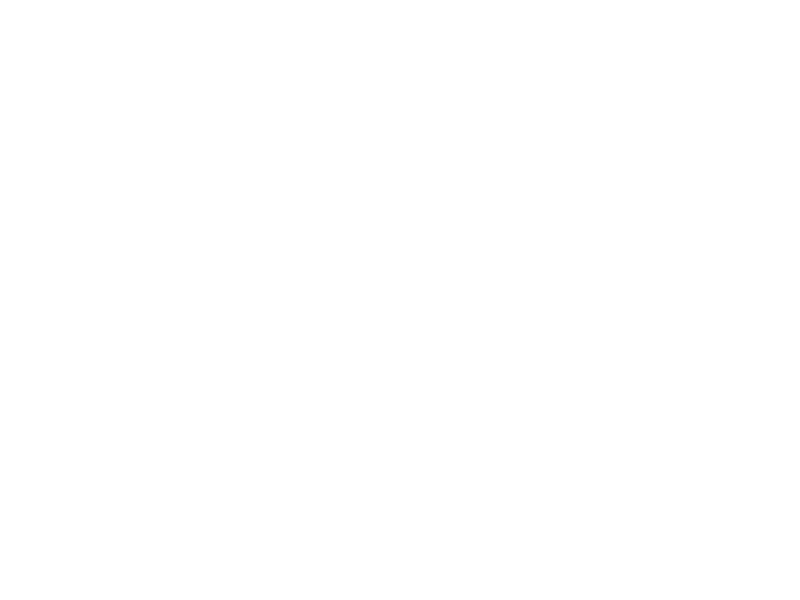

In [3]:
%matplotlib notebook

scenes=[Scene([PointsCollection([(1, 2), (3, 1.5), (2, -1)]), 
               PointsCollection([(5, -2), (2, 2), (-2, -1)], 'green', marker = "^")], 
              [LinesCollection([[(1,2),(2,3)], [(0,1),(1,0)]], 'orange')]), 
        Scene([PointsCollection([(1, 2), (-15, 1.5), (2, -1)], 'red'), 
               PointsCollection([(5, -2), (2, 2), (-2, 1)], 'black')], 
              [LinesCollection([[(-1,2),(-2,3)], [(0,-1),(-1,0)]])])]

plot = Plot(scenes)
plot.draw() 


### Rozwiązanie

In [4]:
%matplotlib notebook

import math
import random

def randFloat(a,b):
    return (b-a)*random.random() + a

def randPointsInsideRectangle(a,b,count):
    return [(randFloat(a,b), randFloat(a,b)) for i in range(count)]

def randPointsOnCircle(ox, oy, r, count):
    result = []
    for i in range(count):
        phi = randFloat(0, 2*math.pi)
        result.append((r*math.cos(phi) + ox, r*math.sin(phi) + oy))
    return result

def randPointsOnRectangle(x0, y0, x1, y1, count):
    result = []
    a = x1 - x0
    b = y1 - y0
    circumference = 2*(a+b)
    for i in range(count):
        tmp = randFloat(0, circumference)
        x = x0
        y = y0
        x += tmp
        if x > x1:
            tmp -= 20
            x = x1
            y += tmp
            if y > y1:
                tmp -= 20
                y = y1
                x -= tmp    
                if x < x0:
                    tmp -= 20
                    x = x0
                    y -= tmp
        result.append((x, y))
    return result

def randPointsOnAxisAndDiagonals(a, countAxle, countDiagonal):
    result = [(0,0), (0,a), (a,0), (a,a)]
    for i in range(countAxle):
        result.append((0, randFloat(0,10)))
        result.append((randFloat(0,10), 0))
    for i in range(countDiagonal):
        d = randFloat(0, 10)
        result.append((d, d))
        d = randFloat(0, 10)
        result.append((10 - d, d))
    return result 


<IPython.core.display.Javascript object>


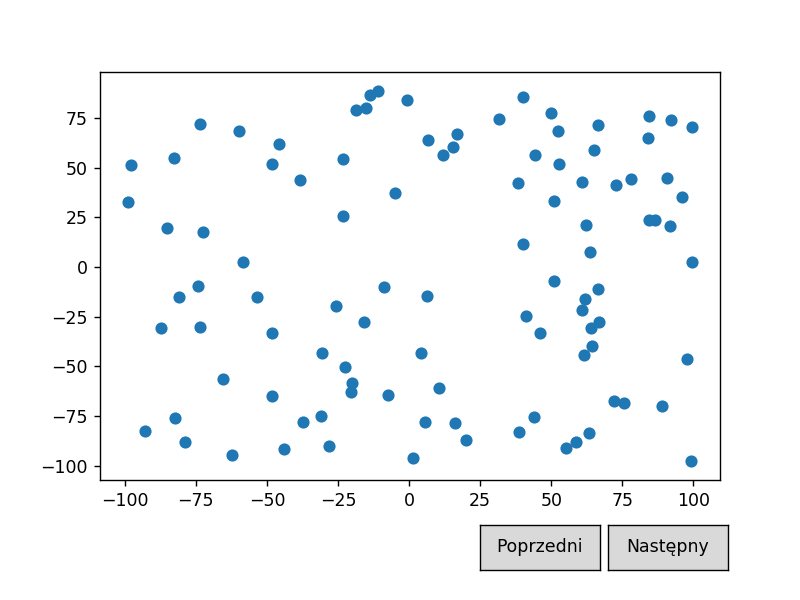

In [21]:
randPointsA = randPointsInsideRectangle(-100,100,100)
randPointsB = randPointsOnCircle(0,0,10,100)
randPointsC = randPointsOnRectangle(-10,-10,10,10,100)
randPointsD = randPointsOnAxisAndDiagonals(10,25,20)
        
scenes = [Scene([PointsCollection(randPointsA)]), 
          Scene([PointsCollection(randPointsB)]), 
          Scene([PointsCollection(randPointsC)]), 
          Scene([PointsCollection(randPointsD)])]
randPlot = Plot(scenes)
randPlot.draw()

In [22]:
EPSILON = 10**(-12)

def det3(a, b, c):
    return a[0]*b[1] + a[1]*c[0] + b[0]*c[1] - b[1]*c[0] - a[1]*b[0] - a[0]*c[1]

def sqrD(p1, p2):
    return (p1[0] - p2[0])**2 + (p1[1] - p2[1])**2 

class PointWithRoot:
    def __init__(self, point, root):
        self.point = point
        self.root = root
    def sqrDToRoot(self):
        return (self.point[0] - self.root[0])**2 + (self.point[1] - self.root[1])**2
    def __lt__(self, other):
        tmpDet3 = det3(self.root, self.point, other.point)
        return tmpDet3 >= EPSILON or (abs(tmpDet3) < EPSILON and self.sqrDToRoot() < other.sqrDToRoot())

def findLowestPoint(points):
    mini = points[0]
    idx = 0
    for (i, (x, y)) in enumerate(points[1:len(points)]):
        if y < mini[1]:
            mini = (x, y)
            idx = i + 1
        elif y == mini[1] and x < mini[0]:
            mini = (x, y)
            idx = i + 1
    return (idx, mini)

def grahamAlgorithm(myPoints):
    points = myPoints.copy()
    (idx, mini) = findLowestPoint(points)
    points.pop(idx)
    
    #Sorting points by angle (p1, mini, p2)
    consideredPoints = []
    for point in points:
        consideredPoints.append(PointWithRoot(point, mini))
    consideredPoints.sort()
    
    #Deleting points on any line [mini, point]
    l = len(consideredPoints)
    i = 0
    while i < l-1:
        if abs(det3(mini, consideredPoints[i].point, consideredPoints[i+1].point)) < EPSILON:
            l = l-1
            consideredPoints.pop(i)
        else:
            i = i+1
    
    #Adding mini as last point to consider
    consideredPoints.append(PointWithRoot(mini, mini))
    
    #Init of resultStack
    resultStack = [consideredPoints[1].point, consideredPoints[0].point, mini]
    
    #List of lines in current convex closure (used to visualize)
    consideredPoints.pop(0)
    consideredPoints.pop(0)
    for p in consideredPoints:
        tmpDet = det3(resultStack[1], resultStack[0], p.point)
        if abs(tmpDet) < EPSILON:
            #Deletion of collinear point
            resultStack.pop(0)
        else:
            #Repairing result stack to be convex
            while abs(tmpDet) > EPSILON and tmpDet < 0:
                resultStack.pop(0)
                tmpDet = det3(resultStack[1], resultStack[0], p.point)
        #Adding finally processed point
        resultStack.insert(0, p.point)
    return resultStack
    
    
def grahamWithPlot(myPoints):
    points = myPoints.copy()
    (idx, mini) = findLowestPoint(points)
    points.pop(idx)
    
    #Sorting points by angle (p1, mini, p2)
    consideredPoints = []
    for point in points:
        consideredPoints.append(PointWithRoot(point, mini))
    consideredPoints.sort()
    
    #Deleting points on any line [mini, point]
    l = len(consideredPoints)
    i = 0
    while i < l-1:
        if abs(det3(mini, consideredPoints[i].point, consideredPoints[i+1].point)) < EPSILON:
            l = l-1
            consideredPoints.pop(i)
        else:
            i = i+1
    
    #Adding mini as last point to consider
    consideredPoints.append(PointWithRoot(mini, mini))
    
    #Init of resultStack
    resultStack = [consideredPoints[1].point, consideredPoints[0].point, mini]
    
    #List of lines in current convex closure (used to visualize)
    linesCollStack = [LinesCollection([[consideredPoints[0].point, consideredPoints[1].point]], color = "orange"),
                      LinesCollection([[mini, consideredPoints[0].point]], color = "orange")]
    consideredPoints.pop(0)
    consideredPoints.pop(0)
    
    scenesStack = []
    scenesStack.append(Scene([PointsCollection(myPoints), 
                            PointsCollection(resultStack, color="orange", marker ="*")],
                            linesCollStack.copy()))
    for p in consideredPoints:
        #Scene with considered line
        consideredLine = LinesCollection([[resultStack[0], p.point]],color = "yellow")
        scenesStack.append(Scene([PointsCollection(myPoints), 
                                  PointsCollection(resultStack, color="orange", marker ="*"),
                                  PointsCollection([p.point], color="yellow")],
                                 linesCollStack.copy() + [consideredLine]))
        tmpDet = det3(resultStack[1], resultStack[0], p.point)
        if abs(tmpDet) < EPSILON:
            #Deletion of collinear point
            linesCollStack.pop(0)
            resultStack.pop(0)
        else:
            #Repairing result stack to be convex
            while abs(tmpDet) > EPSILON and tmpDet < 0:
                linesCollStack.pop(0)
                resultStack.pop(0)
                tmpDet = det3(resultStack[1], resultStack[0], p.point)
                
                #Scene with considered line
                consideredLine = LinesCollection([[resultStack[0], p.point]],color = "yellow")
                scenesStack.append(Scene([PointsCollection(myPoints), 
                                          PointsCollection(resultStack, color="orange", marker ="*"),
                                          PointsCollection([p.point], color="yellow")],
                                         linesCollStack.copy() + [consideredLine]))         
        #Adding finally processed point
        resultStack.insert(0, p.point)
        linesCollStack.insert(0, LinesCollection([[resultStack[1], resultStack[0]]], color="orange"))
        scenesStack.append(Scene([PointsCollection(myPoints), 
                            PointsCollection(resultStack, color="orange", marker ="*")],
                            linesCollStack[0:len(linesCollStack)]))
    return (resultStack, scenesStack)
    
            
        

In [23]:
def compareByAngle(a,b,c):
    tmpDet = det3(a,b,c)
    if abs(tmpDet) < EPSILON:
        return 0
    if tmpDet > 0:
        return 1
    else:
        return -1
    
def findLowestByAngle(points, root):
    mini = points[0]
    idx = 0
    for (i,p) in enumerate(points[1:len(points)]):
        tmpCmp = compareByAngle(root, mini, p)
        if tmpCmp == -1:
            mini = p
            idx = i + 1
        elif tmpCmp == 0:
            if sqrD(root, mini) < sqrD(root, p):
                mini = p
                idx = i + 1
    return (idx, mini)

def jarvisAlgorithm(myPoints):
    points = myPoints.copy()
    
    #Finding starting point
    (idx, mini) = findLowestPoint(points)
    points.pop(idx)
    
    #Finding second point
    (idx, last) = findLowestByAngle(points,mini)
    points.pop(idx)
    
    #Init result stack
    resultStack = [last, mini]
    
    points.append(mini)
    
    #Looping until closure gets to starting point
    while last != mini:
        #Finding closest point (by angle, counterclockwise) to last found
        (idx, last) = findLowestByAngle(points, last)
        resultStack.insert(0, last)
        points.pop(idx)
    return resultStack
    
def jarvisWithPlot(myPoints):
    points = myPoints.copy()
    
    #Finding starting point
    (idx, mini) = findLowestPoint(points)
    points.pop(idx)
    
    #Finding second point
    (idx, last) = findLowestByAngle(points,mini)
    points.pop(idx)
    
    #Init result stack
    resultStack = [last, mini]
    
    #List of lines in current convex closure (used to visualize)
    linesCollStack = [LinesCollection([[resultStack[0], resultStack[1]]], color="orange")]
    scenesStack = [Scene([PointsCollection(myPoints), 
                         PointsCollection(resultStack, color = "orange", marker = "*")], 
                         [linesCollStack[0]])]
    
    points.append(mini)
    
    #Looping until closure gets to starting point
    while last != mini:
        #Finding closest point (by angle, counterclockwise) to last found
        (idx, last) = findLowestByAngle(points, last)
        resultStack.insert(0, last)
        linesCollStack.append(LinesCollection([[resultStack[0], resultStack[1]]], color="orange"))
        scenesStack.append(Scene([PointsCollection(myPoints),
                                  PointsCollection(resultStack, color = "orange", marker = "*")],
                                   linesCollStack.copy()))
        points.pop(idx)
    return (resultStack, scenesStack)
        

In [24]:
import time
import os

def convexClosureWithStats(points, closureAlgorithm):
    startTime = time.time()
    (gr, scenes) = closureAlgorithm(points)
    elapsedTime = time.time() - startTime
    print("Wielkość otoczki: " + str(len(gr)))
    print("Czas wykonania algorytmu " + str(elapsedTime) + " sekund")
    return (gr, scenes)

def grahamWithStats(points):
    print("Wynik dla algorytmu Grahama")
    return convexClosureWithStats(points, grahamWithPlot)
    
def jarvisWithStats(points):
    print("Wynik dla algorytmu Jarvisa")
    return convexClosureWithStats(points, jarvisWithPlot)

def saveClosureToFile(closureStack, name):
    plot.draw()
    if os.path.exists(name):
        i = 1
        while os.path.exists(name + str(i)):
            i += 1
        name += str(i)
    file = open(name, "w")
    for p in gr:
        file.write(str(p) + "\n")
    file.close()

Wynik dla algorytmu Grahama
Wielkość otoczki: 15
Czas wykonania algorytmu 0.0311276912689209 sekund


<IPython.core.display.Javascript object>


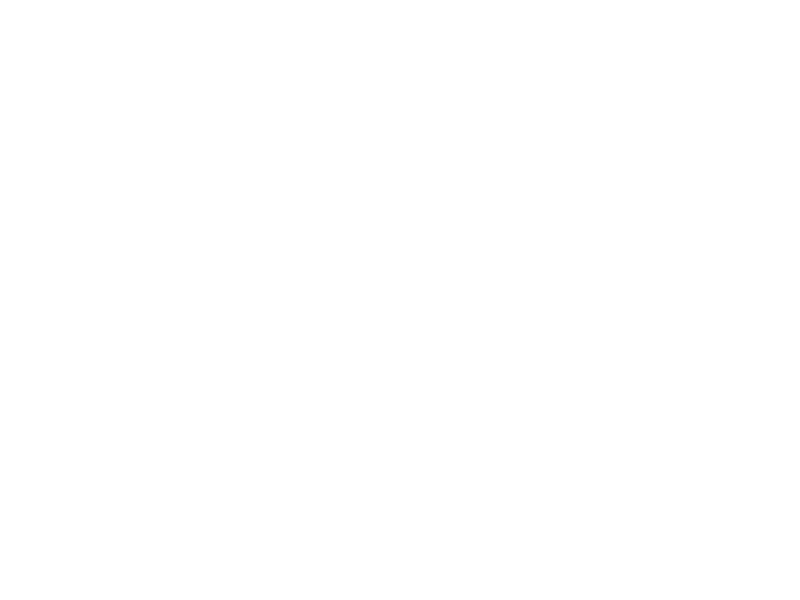

<IPython.core.display.Javascript object>


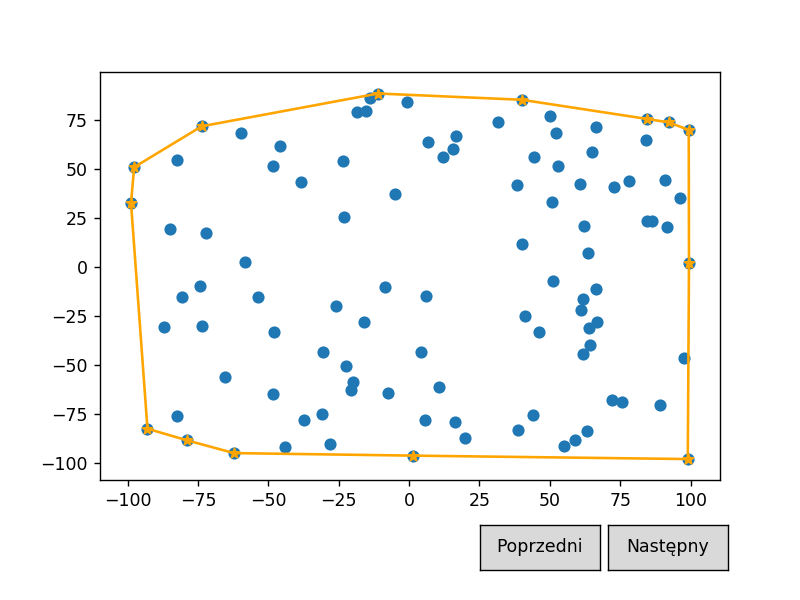

In [25]:
(gr, scenes) = grahamWithStats(randPointsA)
plot = Plot(scenes)
plot.draw()
saveClosureToFile(gr, "resultA")

Wynik dla algorytmu Grahama
Wielkość otoczki: 101
Czas wykonania algorytmu 0.0 sekund


<IPython.core.display.Javascript object>


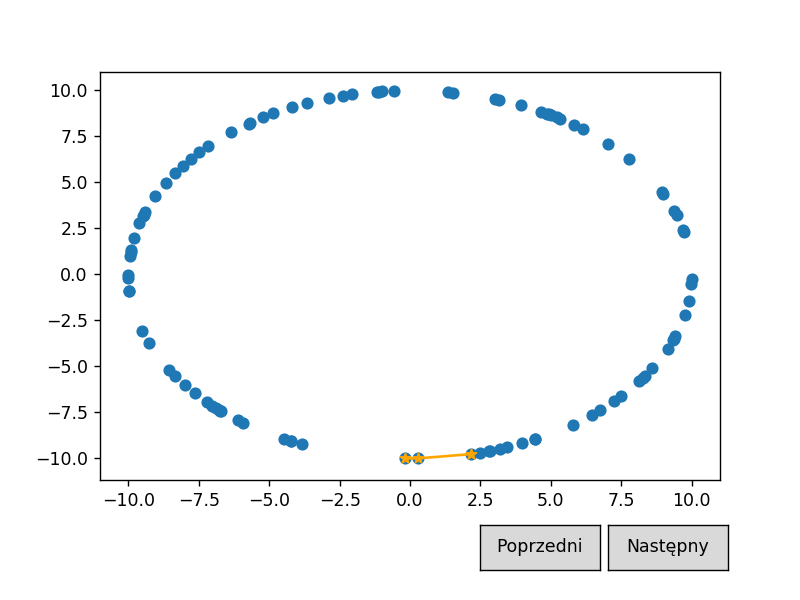

In [26]:
(gr, scenes) = grahamWithStats(randPointsB)
plot = Plot(scenes)
plot.draw()

Wynik dla algorytmu Grahama
Wielkość otoczki: 9
Czas wykonania algorytmu 0.0 sekund


<IPython.core.display.Javascript object>


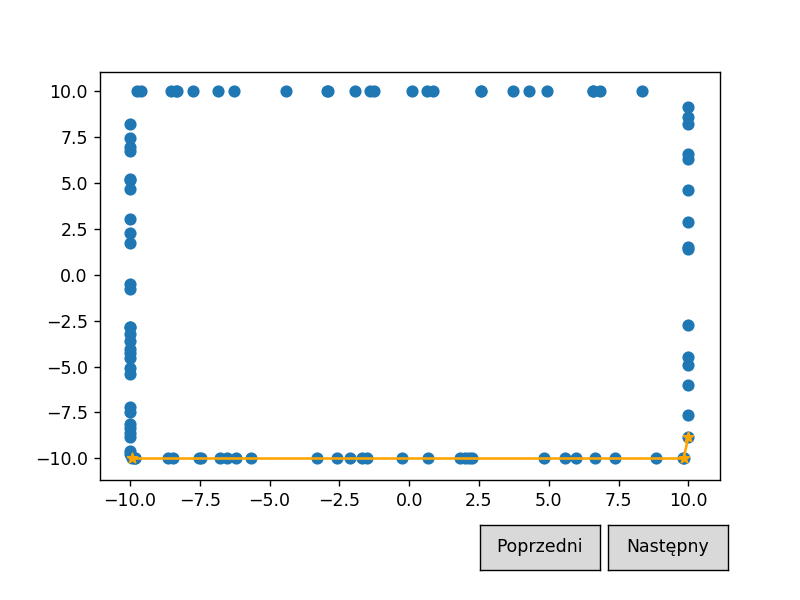

In [27]:
(gr, scenes) = grahamWithStats(randPointsC)
plot = Plot(scenes)
plot.draw()

Wynik dla algorytmu Grahama
Wielkość otoczki: 5
Czas wykonania algorytmu 0.0 sekund


<IPython.core.display.Javascript object>


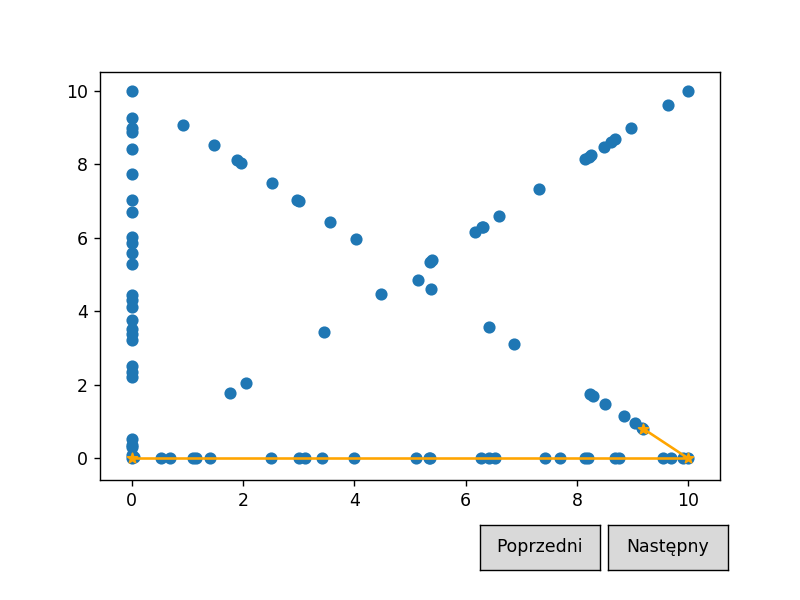

In [28]:
(gr, scenes) = grahamWithStats(randPointsD)
plot = Plot(scenes)
plot.draw()

Wynik dla algorytmu Jarvisa
Wielkość otoczki: 15
Czas wykonania algorytmu 0.0 sekund


<IPython.core.display.Javascript object>


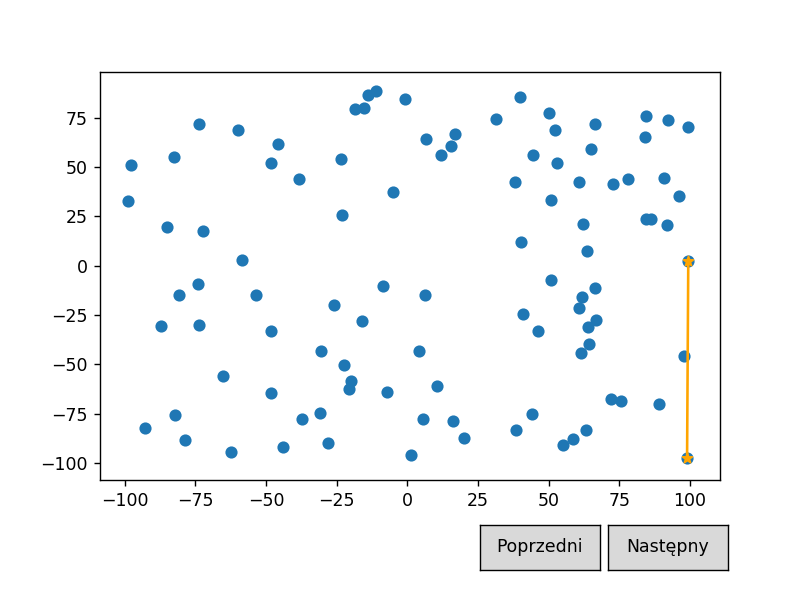

In [29]:
(jar, scenes) = jarvisWithStats(randPointsA)
plot = Plot(scenes)
plot.draw()

Wynik dla algorytmu Jarvisa
Wielkość otoczki: 101
Czas wykonania algorytmu 0.015468120574951172 sekund


<IPython.core.display.Javascript object>


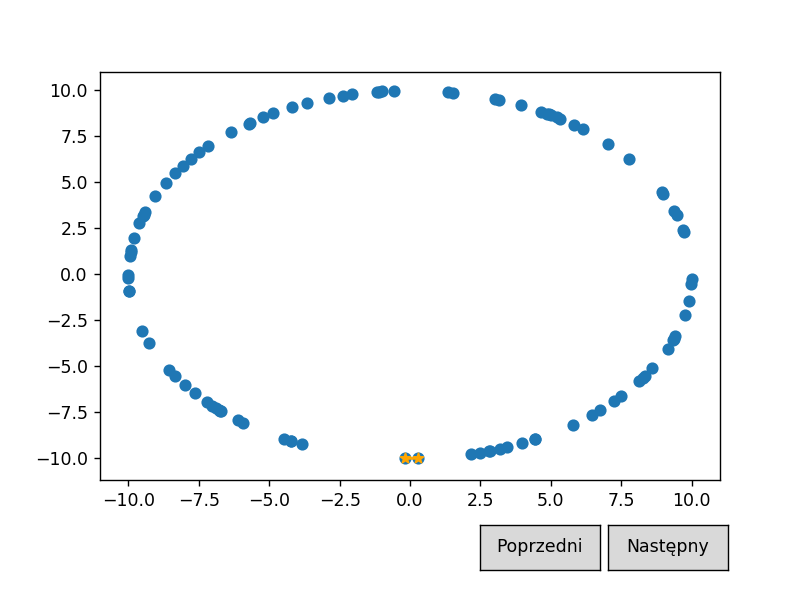

In [30]:
(jar, scenes) = jarvisWithStats(randPointsB)
plot = Plot(scenes)
plot.draw()

Wynik dla algorytmu Jarvisa
Wielkość otoczki: 9
Czas wykonania algorytmu 0.0 sekund


<IPython.core.display.Javascript object>


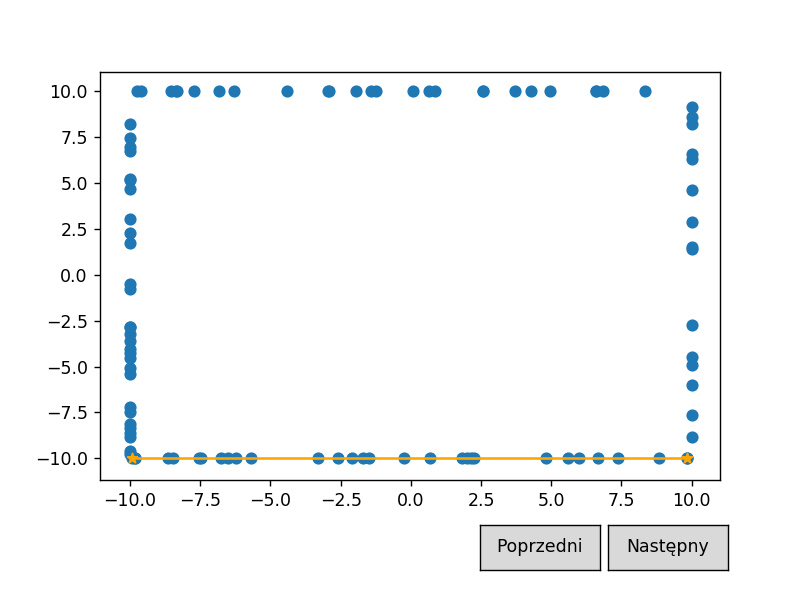

In [31]:
(jar, scenes) = jarvisWithStats(randPointsC)
plot = Plot(scenes)
plot.draw()

Wynik dla algorytmu Jarvisa
Wielkość otoczki: 5
Czas wykonania algorytmu 0.0 sekund


<IPython.core.display.Javascript object>


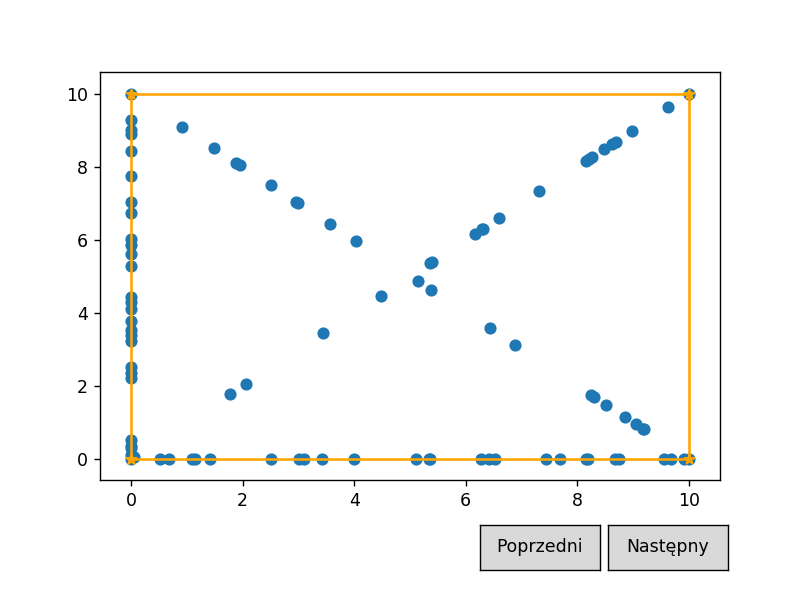

In [32]:
(jar, scenes) = jarvisWithStats(randPointsD)
plot = Plot(scenes)
plot.draw()

In [19]:
def withoutPlotTime(points):
    print(str(len(points)) + " losowych punktów")
    startTime = time.time()
    grahamAlgorithm(points)
    elapsedTime = time.time() - startTime
    print("Graham: " + str(elapsedTime) + " sekund")
    startTime = time.time()
    jarvisAlgorithm(points)
    elapsedTime = time.time() - startTime
    print("Jarvis: " + str(elapsedTime) + " sekund\n")

In [33]:
withoutPlotTime(randPointsInsideRectangle(-100,100,100))
withoutPlotTime(randPointsInsideRectangle(-100,100,1000))
withoutPlotTime(randPointsInsideRectangle(-100,100,10000))
withoutPlotTime(randPointsInsideRectangle(-100,100,100000))
withoutPlotTime(randPointsInsideRectangle(-100,100,1000000))

100 losowych punktów
Graham: 0.0009968280792236328 sekund
Jarvis: 0.000997304916381836 sekund

1000 losowych punktów
Graham: 0.011968851089477539 sekund
Jarvis: 0.02094268798828125 sekund

10000 losowych punktów
Graham: 0.11430168151855469 sekund
Jarvis: 0.1820826530456543 sekund

100000 losowych punktów
Graham: 1.6057381629943848 sekund
Jarvis: 2.4260072708129883 sekund

1000000 losowych punktów
Graham: 21.595966339111328 sekund
Jarvis: 29.579211473464966 sekund

